# Importing necessary Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Loading Data

In [2]:
data = pd.read_csv('/content/rfm_data.csv')
data.head()

,CustomerID,PurchaseDate,TransactionAmount,ProductInformation,OrderID,Location
0,8814,2023-04-11,943.31,Product C,890075,Tokyo
1,2188,2023-04-11,463.70,Product A,176819,London
2,4608,2023-04-11,80.28,Product A,340062,New York
3,2559,2023-04-11,221.29,Product A,239145,London
4,9482,2023-04-11,739.56,Product A,194545,Paris


In [3]:
data.shape

(1000, 6)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CustomerID          1000 non-null   int64  
 1   PurchaseDate        1000 non-null   object 
 2   TransactionAmount   1000 non-null   float64
 3   ProductInformation  1000 non-null   object 
 4   OrderID             1000 non-null   int64  
 5   Location            1000 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 47.0+ KB


In [5]:
data.describe()

,CustomerID,TransactionAmount,OrderID
count,1000.000000,1000.00000,1000.000000
mean,5554.789000,513.67781,554071.398000
std,2605.014863,286.09870,264695.448814
min,1011.000000,12.13000,100096.000000
25%,3273.000000,257.12000,313152.000000
50%,5538.000000,523.56500,564671.500000
75%,7821.750000,759.86000,783052.250000
max,9991.000000,999.44000,999695.000000


# Data Processing

In [6]:
data.isna().any(axis = 1).sum()

0

In [7]:
data.duplicated().sum()

0

**`PurchaseDate` Column should be datetime data type so let's convert it**

In [8]:
data['PurchaseDate'] = pd.to_datetime(data['PurchaseDate'])

In [9]:
data.dtypes

CustomerID                     int64
PurchaseDate          datetime64[ns]
TransactionAmount            float64
ProductInformation            object
OrderID                        int64
Location                      object
dtype: object

**now Our data ready to analysis**

# EDA

## RFM Analysis

RFM analysis is a powerful technique used by companies to better understand customer behaviour and optimize engagement strategies. It revolves around three key dimensions: `recency`, `frequency`, and `monetary` value. These dimensions capture essential aspects of customer transactions, providing valuable information for segmentation and personalized marketing campaigns.

### Calculate Recency & Frequency & Monetary


In [10]:
today = pd.to_datetime('2023-10-10')
data['Recency'] = (today - data['PurchaseDate']).dt.days

In [11]:
data = data.groupby(['CustomerID']).agg({'OrderID':'count',                  # aggregating Functions
                                   'TransactionAmount':'sum',
                                   'Recency':'min'
                                   }).rename(columns = {                     # Renaming Columns
                                    'OrderID': 'Frequency',
                                    'TransactionAmount': 'MonetaryValue'})

In [12]:
data.reset_index(inplace = True)
data.head()

,CustomerID,Frequency,MonetaryValue,Recency
0,1011,2,1129.02,155
1,1025,1,359.29,143
2,1029,1,704.99,122
3,1046,1,859.82,165
4,1049,1,225.72,135


###Calculating RFM Scores


In [13]:
recency_scores = [5, 4, 3, 2, 1]
frequency_scores = [1, 2, 3, 4, 5]
monetary_scores = [1, 2, 3, 4, 5]

In [14]:
data['Recency'] = pd.cut(data['Recency'] , bins = 5 , labels = recency_scores)
data['Frequency'] = pd.cut(data['Frequency'] , bins = 5 , labels = frequency_scores)
data['MonetaryValue'] = pd.cut(data['MonetaryValue'] , bins = 5 , labels = monetary_scores)

In [15]:
data.head()

,CustomerID,Frequency,MonetaryValue,Recency
0,1011,3,3,3
1,1025,1,1,4
2,1029,1,2,5
3,1046,1,2,2
4,1049,1,1,4


**RFM Scores**

In [16]:
data['Frequency'] = data['Frequency'].astype(int)
data['MonetaryValue'] = data['MonetaryValue'].astype(int)
data['Recency'] = data['Recency'].astype(int)

In [17]:
data['RFM_Score'] = data['Frequency'] + data['MonetaryValue'] + data['Recency']

In [18]:
segmant_labels = ['very low','low','medium','high']
data['Segment'] = pd.cut(data['RFM_Score'] , bins = 4 , labels = segmant_labels)

<Axes: xlabel='Segment', ylabel='count'>

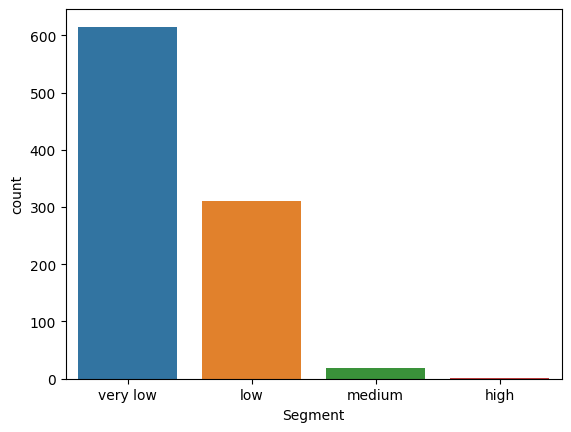

In [19]:
sns.countplot(data = data , x = 'Segment')

In [20]:
data['Segment'].value_counts()

very low    615
low         310
medium       19
high          2
Name: Segment, dtype: int64

### RFM Customer Segments

Now let’s analyze RFM Customer Segments which classifications based on the RFM scores. These segments, such as “Champions”, “Potential Loyalists”, and “Can’t Lose” provide a more strategic perspective on customer behaviour and characteristics in terms of recency, frequency, and monetary aspects.



**Champions**: Bought recently, buy often and spend the most
Loyal customers: Buy on a regular basis. Responsive to promotions.

**Potential loyalis**t: Recent customers with average frequency.

**Recent customers:** Bought most recently, but not often.

**Promising:** Recent shoppers, but haven’t spent much.

**Needs attention:** Above average recency, frequency and monetary values. May not have bought very recently though.

**About to sleep:** Below average recency and frequency. Will lose them if not reactivated.

**At risk:** Some time since they’ve purchased. Need to bring them back!

**Can’t lose them:** Used to purchase frequently but haven’t returned for a long time.

**Hibernating:** Last purchase was long back and low number of orders. May be lost.

In [21]:
bins = [0, 1, 2, 4, 6, 8, 10, 15, float('inf')]
labels = ['Inactive', 'Churning', 'Infrequent', 'Regular', 'Engaged', 'Loyal', 'VIP', 'Champions']

In [22]:
data['RFM Customer Segments'] = pd.cut(data['RFM_Score'] , bins = bins , labels = labels)

In [23]:
data.head()

,CustomerID,Frequency,MonetaryValue,Recency,RFM_Score,Segment,RFM Customer Segments
0,1011,3,3,3,9,low,Loyal
1,1025,1,1,4,6,very low,Regular
2,1029,1,2,5,8,low,Engaged
3,1046,1,2,2,5,very low,Regular
4,1049,1,1,4,6,very low,Regular


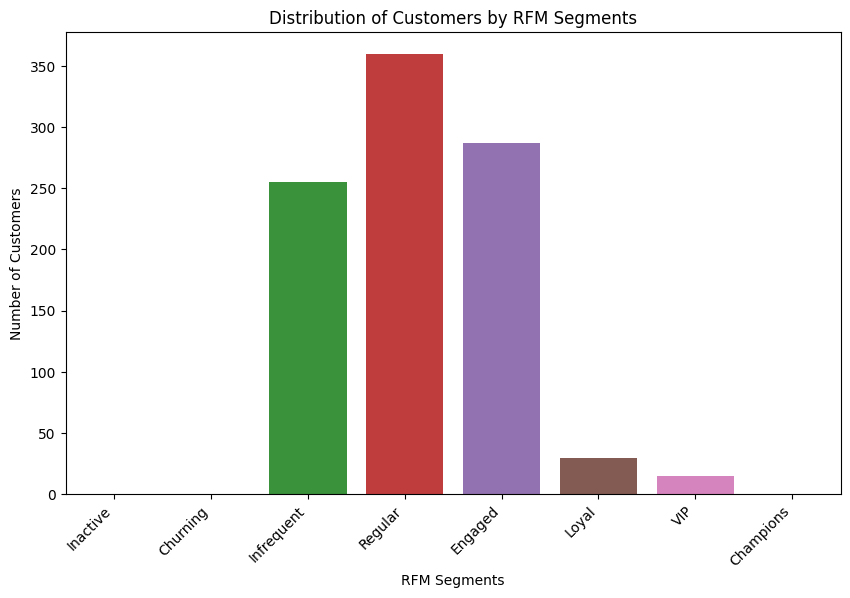

In [24]:
plt.figure(figsize=(10, 6))
sns.countplot(data = data , x = 'RFM Customer Segments' )
plt.xlabel('RFM Segments')
plt.ylabel('Number of Customers')
plt.title('Distribution of Customers by RFM Segments')
plt.xticks(rotation=45, ha="right")

plt.show()

### 'Distribution of RFM Values within Customer Segments

####Distribution of RFM Values within `Loyal` Customer Segments






In [25]:
def Distribution(customer_segmant):
  customer_segmant_data = data[data['RFM Customer Segments'] == customer_segmant]
  plt.figure(figsize=(12, 6))

  plt.subplot(131)
  sns.boxplot(data=customer_segmant_data['Recency'])
  plt.title('Recency')

  plt.subplot(132)
  sns.boxplot(data=customer_segmant_data['Frequency'])
  plt.title('Frequency')

  plt.subplot(133)
  sns.boxplot(data=customer_segmant_data['MonetaryValue'])
  plt.title('Monetary')

  plt.show()

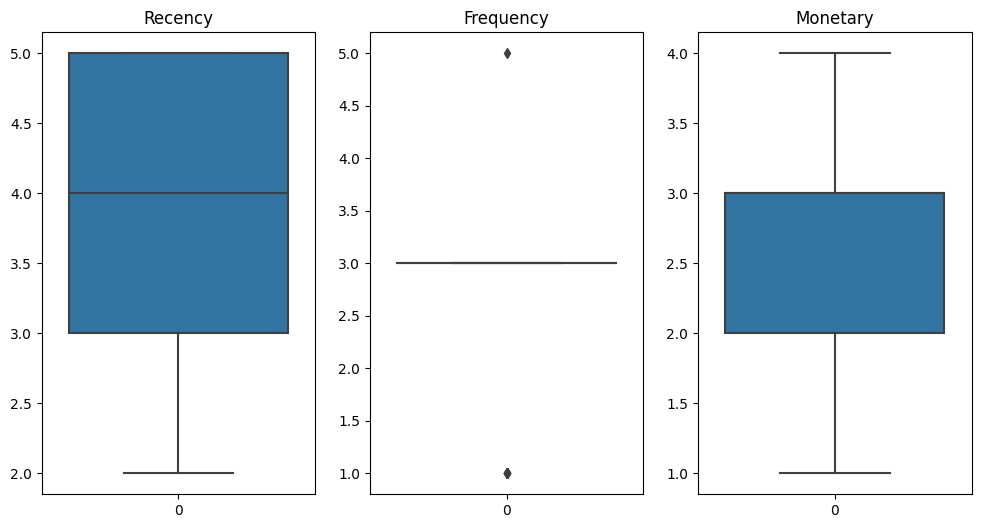

In [26]:
Distribution('Loyal')

#### RFM Overall Distribution

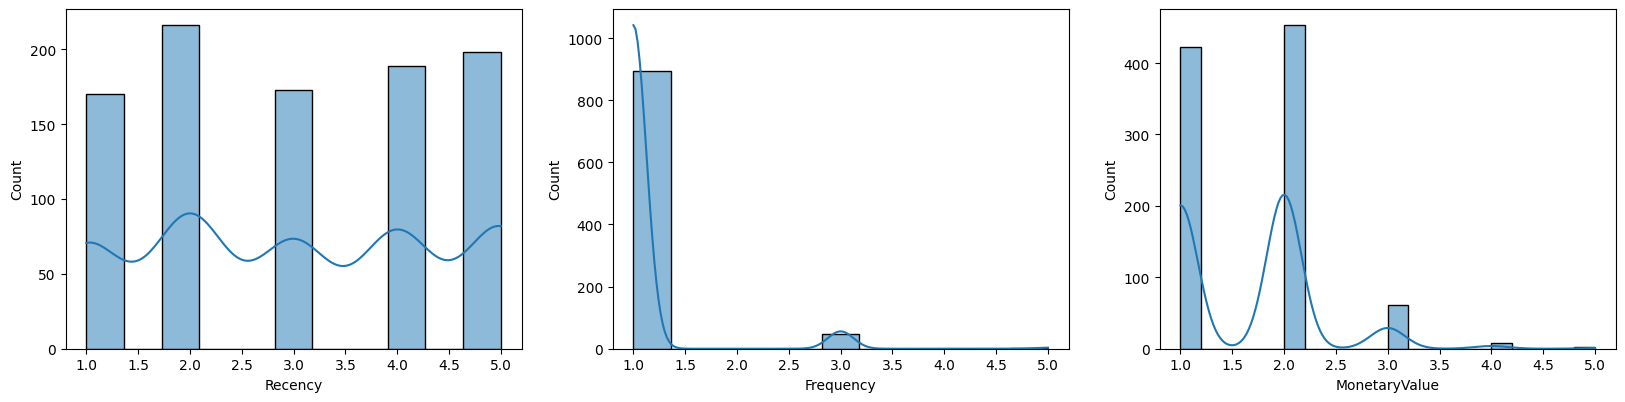

In [27]:
plt.figure(figsize=(20, 15))
plt.subplot(3, 3, 1)
sns.histplot(data['Recency'], kde = 'True')
plt.subplot(3, 3, 2)
sns.histplot(data['Frequency'], kde = 'True')
plt.subplot(3, 3, 3)
sns.histplot(data['MonetaryValue'] , kde = 'True')
plt.show()

### correlation of the recency, frequency, and monetary scores within the `Engaged` segment

In [28]:
Engaged_data = data[data['RFM Customer Segments'] == 'Engaged']
correlation_matrix_1 = Engaged_data[['Frequency', 'Recency', 'MonetaryValue']].corr()
correlation_matrix_1

,Frequency,Recency,MonetaryValue
Frequency,1.000000,-0.630772,0.208967
Recency,-0.630772,1.000000,-0.609186
MonetaryValue,0.208967,-0.609186,1.000000


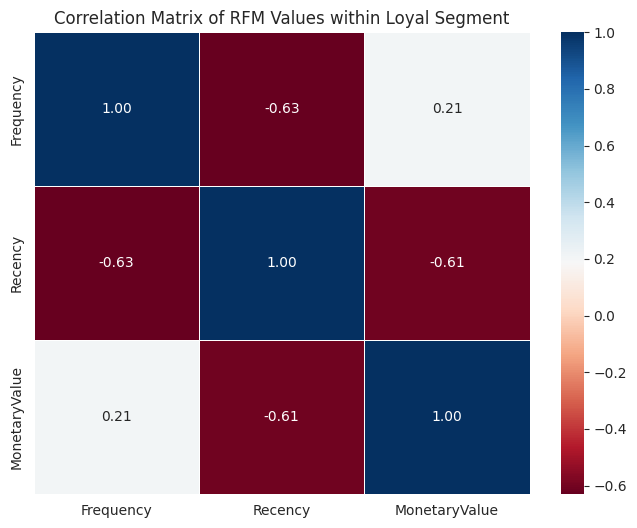

In [29]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.heatmap(data=correlation_matrix_1, annot=True, cmap="RdBu", cbar=True, fmt=".2f", linewidths=0.5)

plt.title('Correlation Matrix of RFM Values within Loyal Segment')
plt.show()

### Recency, Frequency, and Monetary Scores For each Segment

In [30]:
segment_RFM = data.groupby('RFM Customer Segments')['Recency', 'Frequency', 'MonetaryValue'].mean().reset_index()
segment_RFM

<ipython-input-30-a8048ca408c0>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  segment_RFM = data.groupby('RFM Customer Segments')['Recency', 'Frequency', 'MonetaryValue'].mean().reset_index()


,RFM Customer Segments,Recency,Frequency,MonetaryValue
0,Inactive,NaN,NaN,NaN
1,Churning,NaN,NaN,NaN
2,Infrequent,1.364706,1.000000,1.313725
3,Regular,2.875000,1.011111,1.616667
4,Engaged,4.522648,1.083624,1.759582
5,Loyal,4.000000,2.586207,2.620690
6,VIP,4.666667,3.266667,3.666667
7,Champions,NaN,NaN,NaN


In [31]:
segment_RFM = segment_RFM.pivot_table(segment_RFM,index = 'RFM Customer Segments' )
segment_RFM.reset_index(inplace = True)

<Axes: xlabel='RFM Customer Segments'>

<Figure size 1400x600 with 0 Axes>

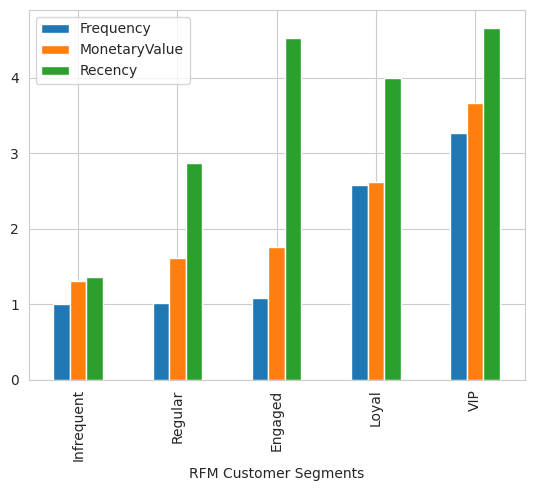

In [32]:
plt.figure(figsize = (14 , 6))
segment_RFM.plot(x = 'RFM Customer Segments',kind = 'bar')

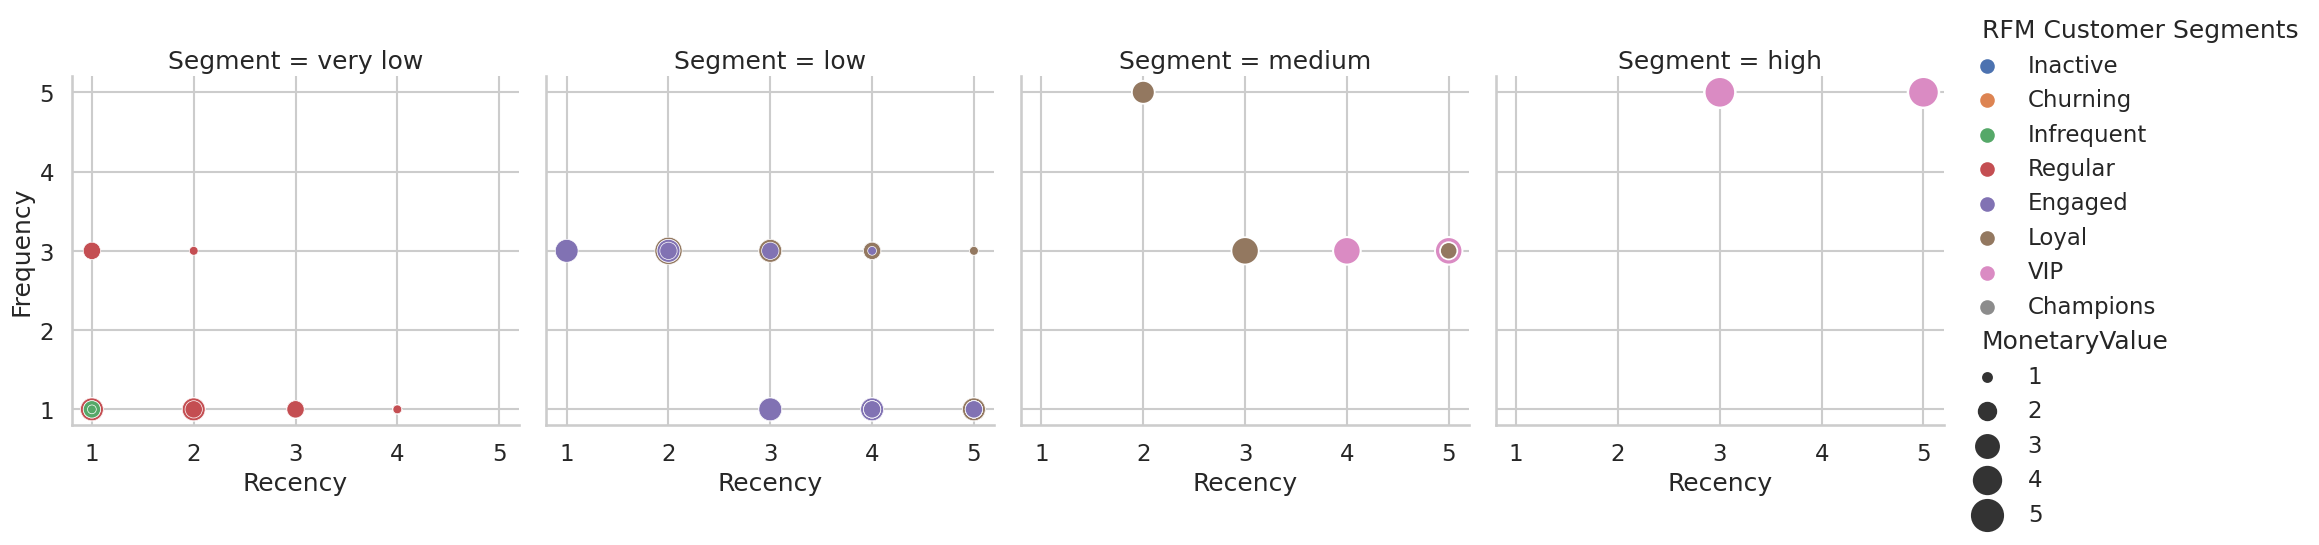

In [33]:
sns.set(style="whitegrid")
sns.set_context("talk")

plot = sns.relplot(
    data=data,
    x='Recency',
    y='Frequency',
    size='MonetaryValue',
    col='Segment',
    hue='RFM Customer Segments',
    sizes=(40, 500)
)

plot.set_xlabels("Recency")
plot.set_ylabels("Frequency")

plt.show()

## Product Analysis

In [34]:
ndata = pd.read_csv('/content/rfm_data.csv')

### What is the total transaction amount for each product ?

In [35]:
amount_trans = ndata.groupby(['ProductInformation'] , as_index = False).agg({'TransactionAmount':'sum','OrderID':'count'})

Text(0.5, 1.0, 'Product VS SUM_TransactionAmount')

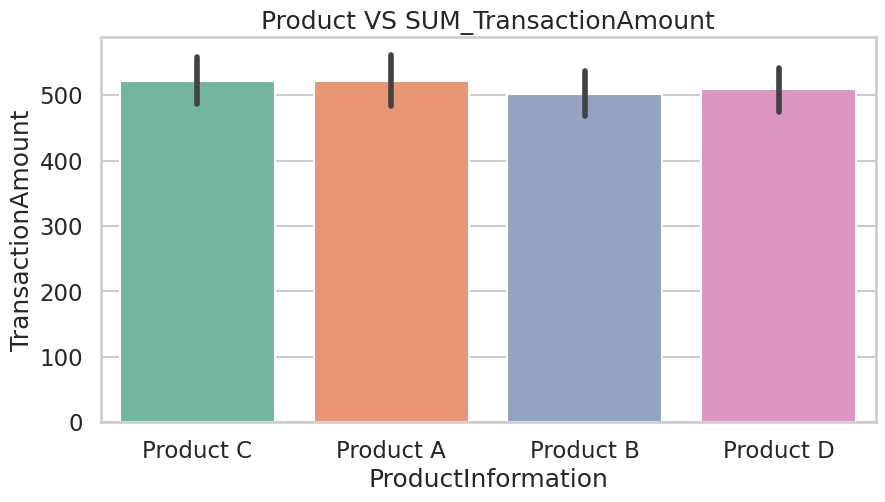

In [36]:
plt.figure(figsize=(10,5))
sns.barplot(data = ndata , x = 'ProductInformation' , y = 'TransactionAmount' , palette = 'Set2')
plt.title("Product VS SUM_TransactionAmount")

### How many Orders for each product ?

Text(0.5, 1.0, 'Product VS Count_of_Orders')

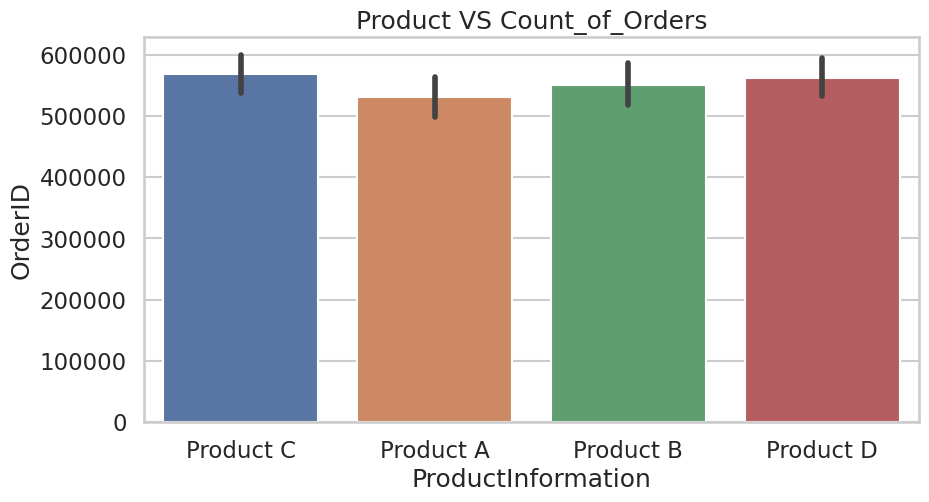

In [37]:
plt.figure(figsize=(10,5))
sns.barplot(data = ndata , x = 'ProductInformation' , y = 'TransactionAmount' , palette = 'Set3')
sns.barplot(data = ndata , x = 'ProductInformation' , y = 'OrderID')
plt.title("Product VS Count_of_Orders")

###What is the most common product category purchased in each location?

In [38]:
Product_of_location = ndata.groupby(['Location' , 'ProductInformation'] , as_index = False).agg({'TransactionAmount':'sum','OrderID':'count'})

In [39]:
def top_1Product(group):
  return group.nlargest(1 ,'OrderID')

In [40]:
Product_of_location = Product_of_location.groupby(['Location'] , group_keys= False).apply(top_1Product).rename(columns = {'OrderID' : 'MostPurchased_order'})

In [41]:
Product_of_location

,Location,ProductInformation,TransactionAmount,MostPurchased_order
2,London,Product C,37930.01,74
7,New York,Product D,39091.19,69
10,Paris,Product C,34838.08,65
14,Tokyo,Product C,39043.83,72


Text(0.5, 1.0, 'Top Product VS Location')

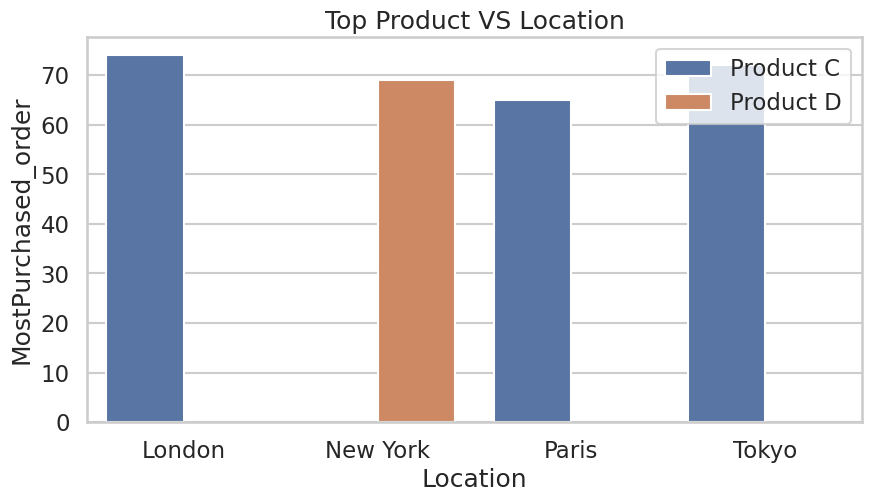

In [42]:
plt.figure(figsize = (10 , 5))
sns.barplot(data = Product_of_location , x = 'Location' , y = 'MostPurchased_order' , hue ='ProductInformation')
plt.legend(loc = 'upper right')
plt.title("Top Product VS Location")

### What is the most common product category greatest Revenue in each location?

In [43]:
def top_1Product(group):
  return group.nlargest(1 ,'TransactionAmount')
Product_of_location_ByRevenue = ndata.groupby(['Location' , 'ProductInformation'] , as_index = False).agg({'TransactionAmount':'sum'})

In [44]:
Product_of_location_ByRevenue = Product_of_location_ByRevenue.groupby('Location' , group_keys=False).apply(top_1Product)

In [45]:
Product_of_location_ByRevenue

,Location,ProductInformation,TransactionAmount
2,London,Product C,37930.01
7,New York,Product D,39091.19
10,Paris,Product C,34838.08
14,Tokyo,Product C,39043.83


<Axes: title={'center': 'Top Product by Revenue VS Location'}, xlabel='Location', ylabel='TransactionAmount'>

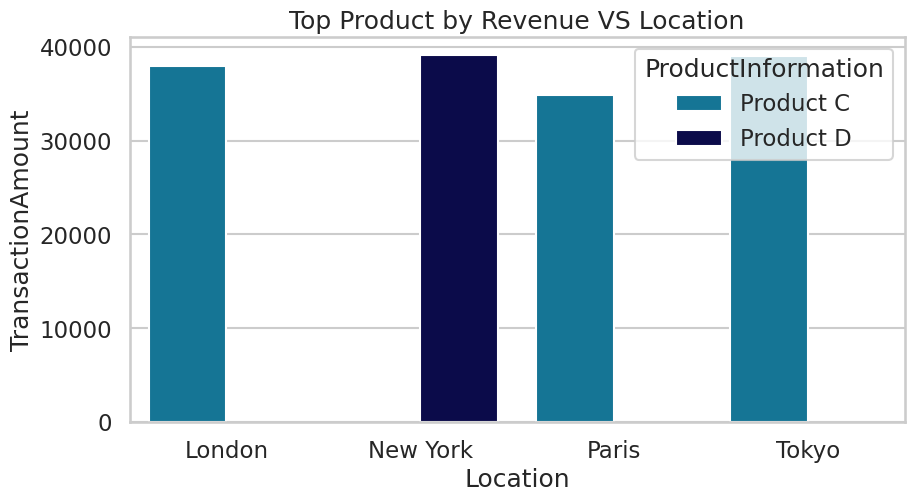

In [46]:
plt.figure(figsize = (10 , 5))
plt.legend(loc = 'upper right')
plt.title("Top Product by Revenue VS Location")
sns.barplot(data = Product_of_location_ByRevenue ,x = 'Location', y = 'TransactionAmount' , hue = 'ProductInformation' , palette='ocean_r')

### Distribution Transaction amount for each Product

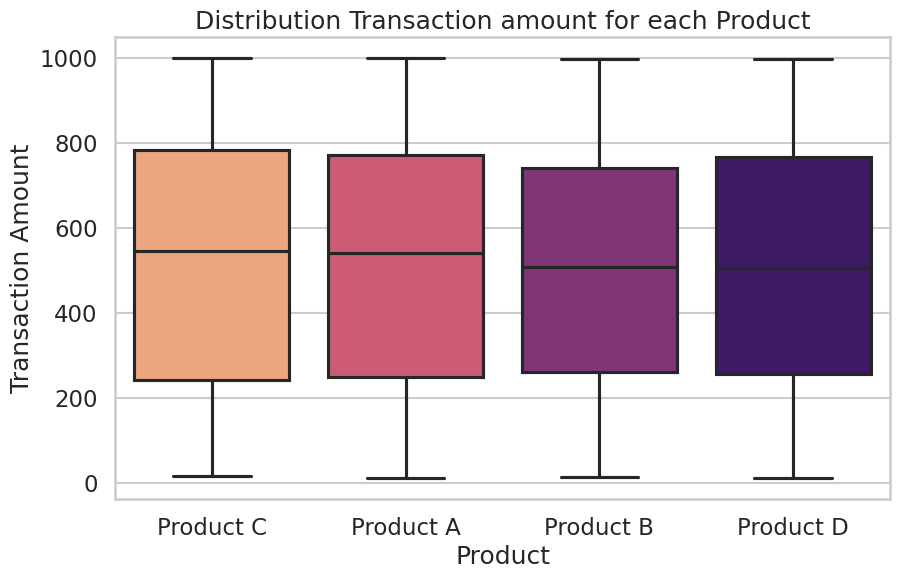

In [47]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=ndata, x='ProductInformation', y='TransactionAmount', palette='magma_r')
plt.xlabel('Product')
plt.ylabel('Transaction Amount')
plt.title('Distribution Transaction amount for each Product')
plt.show()

##Time Series Analysis:


### any patterns or trends in Count of Orders?

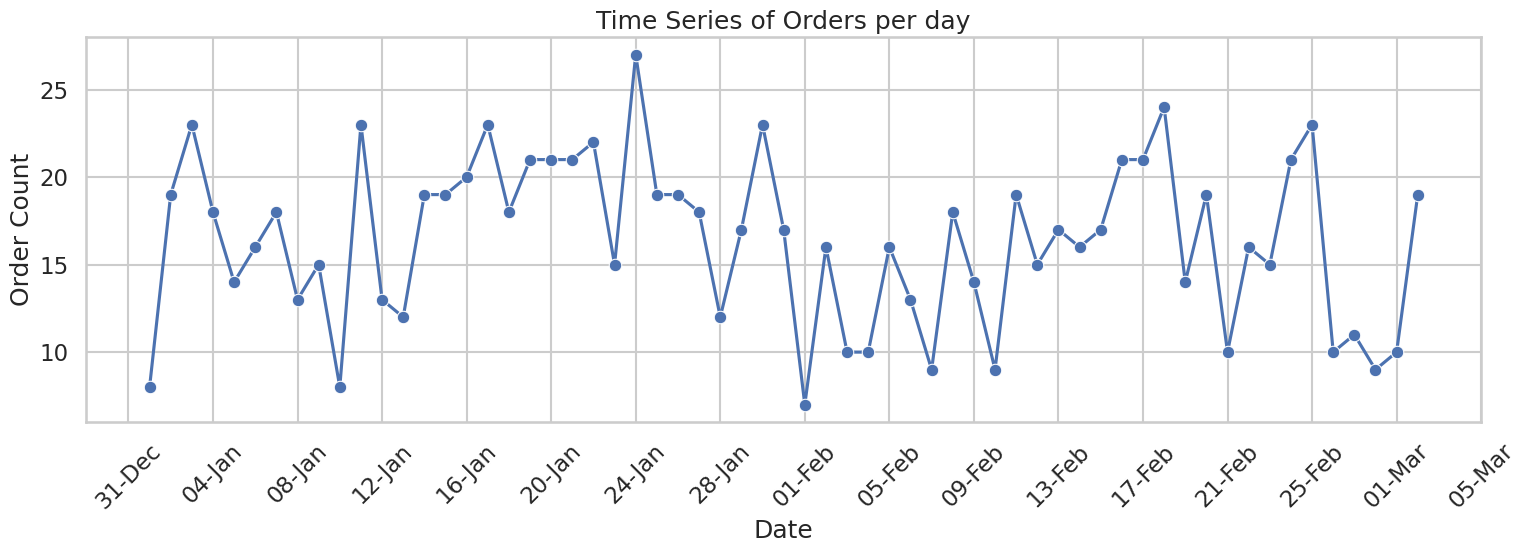

In [48]:
PurchaseDate_data = ndata.groupby(['PurchaseDate'] , as_index = False).agg({'OrderID':'count' ,'TransactionAmount':'sum' })

plt.figure(figsize=(18, 5))
sns.lineplot(data = PurchaseDate_data , x='PurchaseDate', y='OrderID' , marker = 'o')

plt.title('Time Series of Orders per day')
plt.xlabel('Date')
plt.ylabel('Order Count')

import matplotlib.dates as mdates
date_format = mdates.DateFormatter("%d-%b")
plt.gca().xaxis.set_major_formatter(date_format)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))
plt.xticks(rotation=45)

plt.show()

### Transaction Amount for each Month

In [52]:
ndata['PurchaseDate'] = pd.to_datetime(ndata['PurchaseDate'])
ndata['month'] =  ndata['PurchaseDate'].dt.month_name()
PurchaseDate_data_Month = ndata.groupby('month').agg({'TransactionAmount':'sum' })

<Axes: xlabel='month'>

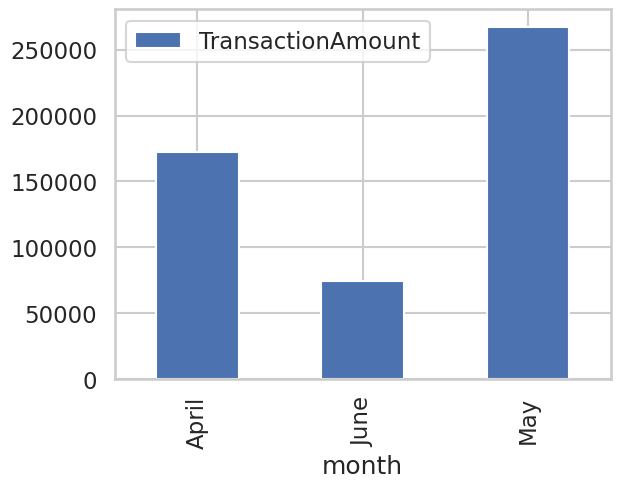

In [53]:
PurchaseDate_data_Month.plot(kind = 'bar')

### Revenue per day for all Months

In [54]:
ndata['day'] =  ndata['PurchaseDate'].dt.day_name()
PurchaseDate_data_day = ndata.groupby('day' , as_index = False).agg({'TransactionAmount':'sum' })

In [55]:
day_dict = {'Saturday': 1, 'Sunday': 2, 'Monday': 3, 'Thursday': 4, 'Wednesday': 5, 'Tuesday': 6, 'Friday': 7}
PurchaseDate_data_day['day'] = pd.Categorical(PurchaseDate_data_day['day'] , categories=day_dict)

In [56]:
PurchaseDate_data_day.sort_values('day' , inplace = True)

<Axes: xlabel='day', ylabel='Revenue'>

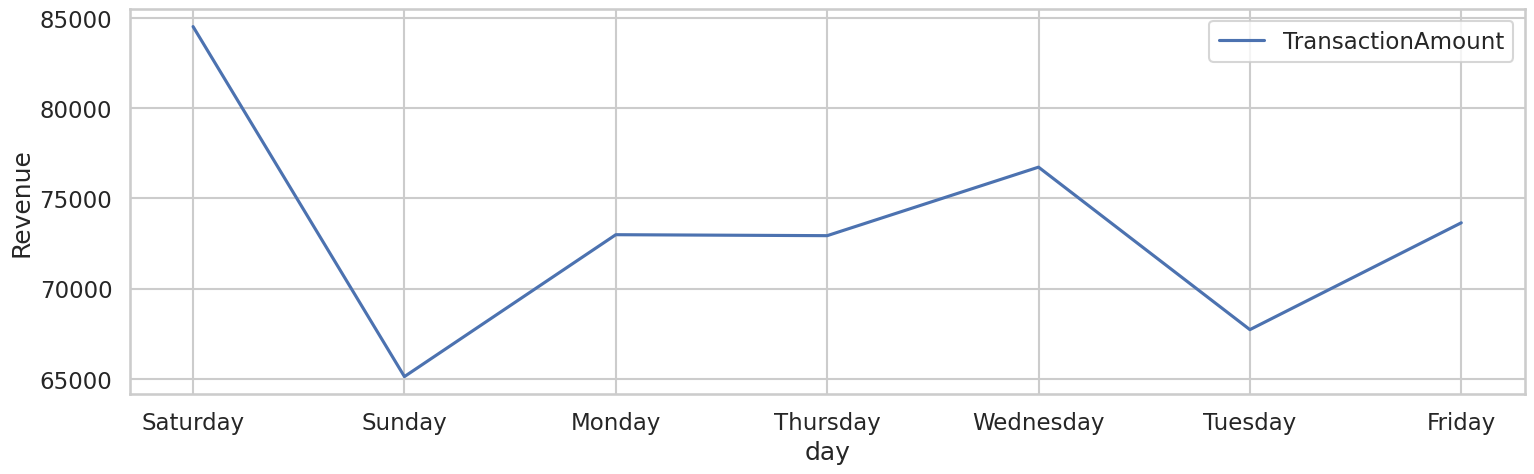

In [58]:
PurchaseDate_data_day.plot(x = 'day',figsize = (18,5) , ylabel = "Revenue")